In [2]:
import itertools
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter

import scipy 
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary, hamming_dist as dist
from Solvers import type_mask, partial, ket, instance_mask, adv_solver
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from time import time
from itertools import product, permutations
mpl.rcParams["figure.dpi"] = 120

In [3]:
def get_oracles(funcs, oracle_getter):
    print('get_oracles', len(funcs))
    return {func: oracle_getter(func) for func in funcs}

def cycle_oracle(func):
    return permutation_oracle(cycle_to_standard(func))

def get_phase_oracles(problem):
    oracles = {}
    # roots = nthRootsOfUnity(n)
    if isinstance(problem, Problem):
        instances = problem.instances
    n = len(instances[0])
    for instance in instances:
        oracle = np.zeros((n,n))
        for i in range(n):
            oracle[i, i] =-1 if instance[i] == 1 else 1
        oracles[instance] = oracle
        
    return oracles
def phase_oracle(func):
    oracle = np.zeros((len(func),len(func)))
    for i in range(len(func)):
        oracle[i,i] = 1 if func[i] == 0 else -1
    return oracle 
def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            # print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        # print(oracles[instance])
    return oracles
def standard_oracle(func, alpha_len=None):
    n = len(func)
    if alpha_len is None:
        alpha_len = n
    oracle = []
    for i in range(n):
        curr_oracle = np.zeros((alpha_len, alpha_len))
        for a in range(alpha_len):
            curr_oracle[a, (func[i] + a) % alpha_len] = 1
            # print(curr_oracle)
        oracle.append(copy(curr_oracle))
    return block_diag(*oracle)

def get_oracle_diffs(oracles, prod=True, mat=False, keys=None):
    oracle_diffs = {}
    # print("keys", keys)
    if keys is None:
        keys = list(oracles.keys())
    # keys.sort()
    for v1 in keys:
        for v2 in keys:
            if prod:
                oracle_diffs[(v1, v2)] = np.eye(oracles[v1].shape[0])- oracles[v1].T @ oracles[v2]
            else:
                # print('normal diff')
                oracle_diffs[(v1, v2)] = oracles[v1] - oracles[v2]
    if mat:
        oracle_diffs =  [
            [
                oracle_diffs[(k1, k2)] for k1 in keys
            ] for k2 in keys
        ]
    return oracle_diffs
def permutation_oracle(perm, nonstandard=False):
    n = len(perm)
    
    oracle = np.zeros((n, n))
    for i in range(n):
        oracle[i, perm[i]] = 1
    return oracle

def get_permutation_oracles(instances):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = len(instances[0])
    print(n)
    # assert tuple(range(n)) == problem.alphabet
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles

def preimage_even_odd(n):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n,n):
        # print(to_str(perm))
        if perm.index(0) >= n//2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    return Problem(no_instances, yes_instances)

In [4]:
def get_cycles(n, k):
    perm = tuple(range(n))
    yes_instances = set()
    for cycle_points in itertools.permutations(perm, k):
        curr_cycle = list(perm)
        for i in range(k-1):
            curr_cycle[cycle_points[i]] = cycle_points[i+1]
        curr_cycle[cycle_points[-1]] = cycle_points[0]
        yes_instances.add(tuple(curr_cycle))
    return list(yes_instances)
def num_fixed_points(perm):
    curr_sum = 0
    for i in range(len(perm)):
        if perm[i] == i:
            curr_sum += 1
    return curr_sum

def permutation_thresh(n, k):
    # perm = nkp.array(range(n))
    no_instances = set()
    yes_instances = set()
    for perm in itertools.permutations(tuple(range(n))):
        num_fixed = num_fixed_points(perm)
        if num_fixed == k:
            no_instances.add(perm)
        elif num_fixed == k + 1:
            yes_instances.add(perm)
    return Problem(list(no_instances), list(yes_instances))
def equality(n):
    perms = list(itertools.permutations(list(range(n))))
    no_instances = []
    yes_instances = [tuple(perm + tuple(p + n for p in perm)) for perm in perms]
    for perm1, perm2 in itertools.combinations_with_replacement(perms, 2):
        instance = tuple(perm1+ tuple(p + n for p in perm2))
        if dist(perm1, perm2) == 2:
            no_instances.append(instance)
    return Problem(no_instances, yes_instances)


def fixed_points(n, k):
    no_instances = []
    yes_instances = []
    for perm in itertools.permutations(range(n)):
        fp = num_fixed_points(perm)
        if fp == k:
            no_instances.append(perm)
        elif fp == k+1:
            yes_instances.append(perm)
    return Problem(no_instances, yes_instances)
        
def cycle0(n, k):
    no_instances = [cycle for cycle in get_cycles(n, k) if cycle[0] != 0]
    yes_instances = [cycle for cycle in get_cycles(n, k+1) if cycle[0] != 0]
    return Problem(no_instances, yes_instances)
def cycle(n, k, k2=None):
    if k2 is None:
        k2 = k+1
    no_instances = get_cycles(n,k)
    yes_instances = get_cycles(n, k2)
    return Problem(no_instances, yes_instances)

def preimage(n, k):
    # perms = list(itertools.permutations(range(n)))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n, k):
        preimage0 = perm.index(0)
        # print(preimage0, perm)
        if preimage0 % 2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    # print(no_instances)
    # print(yes_instances)
    return Problem(no_instances, yes_instances)
def get_all_cycles(perm):
    cycles =[]
    points_in_cycles = set()
    for i in range(n):
        if i not in points_in_cycles and perm[i] != i:
            cycle = [i]
            j = perm[i]
            points_in_cycles.add(j)
            while j not in cycle:
                cycle.append(j)
                j = perm[j]
                points_in_cycles.add(j)
            cycles.append(tuple(cycle))
    return cycles

def num_cycles(perm):
    return len(get_all_cycles(perm))
        
def transpose_thresh(n, k):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in perms:
        cycles = get_all_cycles(perm)
        cycle_lengths = set(len(cycle)  for cycle in cycles)
        if cycle_lengths == set([2]):
            if len(cycles) == k:
                no_instances.append(perm)
            elif len(cycles) == k+1:
                yes_instances.append(perm)
    return Problem(no_instances, yes_instances)

def transpose(n, easy=False):
    perm = tuple(range(n))
    no_instances = []
    if easy:
        for i in range(n//2):
            instance = list(perm)
            instance[2*i] = 2*i + 1
            instance[2*i+1] = 2*i
            no_instances.append(tuple(instance))
    else:
        for i,j in itertools.combinations(perm, 2):
            # print(i,j)
            instance = list(perm)
            instance[i] = j
            instance[j] = i
            no_instances.append(tuple(instance))
    return Problem([perm], list(no_instances))

def relative_hadamard_norm_min(mat, relative, D1_len):
    mat_len = mat.shape[0]
    mat_size = mat_len
    D1 = list(range(D1_len))
    D2 = list(range(D1_len, mat_size))
    relative_shape = relative[0][0].shape
    t = cp.Variable(nonneg=True)
    X = [[cp.Variable(relative_shape) for _ in range(mat_len)] for _ in range(mat_len)]
    for x in D1:
        for y in D2:
            X[x][y] = cp.Variable(relative_shape)
    constraints = [cp.bmat(X) >> 0]
    constraints += [
        mat[x][y] == cp.trace(X[x][y].T @ relative[x][y]) 
        for x in range(mat_size) for y in range(mat_size)
    ]
    constraints += [
        t >= cp.trace(X[z][z]) for z in range(mat_size)
    ]
    
    opt_prob = cp.Problem(cp.Minimize(t), constraints)
    opt_prob.solve(verbose=True) 
    for x in range(mat_size):
        for y in range(mat_size):
            X[x][y] = X[x][y].value
    return X
    
def relative_hadamard_norm_max(mat, relative_mat, D_len, solver="MOSEK", uni=True):
    print('shapes', )
    relative_shape = [0,0]
    relative_shape[0] = relative_mat.shape[0] // mat.shape[0]
    relative_shape[1] = relative_mat.shape[1] // mat.shape[1]
    relative_shape = tuple(relative_shape)
    
    # print(D1_len, len(D2), relative.shape)
    # relative_mat = np.block(relative)

    print(relative_mat.shape)
    Y = cp.Variable((D_len, D_len), PSD=True)
    Lambda = cp.Variable((D_len, D_len), symmetric=True)
    print(relative_shape)
    Lambda_relative = cp.kron(Lambda, np.ones(relative_shape))
    Lambda_relative = cp.multiply(Lambda_relative, relative_mat)
    diag = cp.kron(cp.diag(cp.diag(Y)), np.eye(relative_shape[0]))
    # print(W.shape, diag.shape)
    # W = Lambda_relative - diag
    # print(W)
    constraints = [cp.trace(Y) == 1, Lambda_relative << diag]
    opt_prob = cp.Problem(cp.Maximize(2 * cp.sum(cp.multiply(Lambda.T, mat))), constraints)
    # opt_prob.solve(verbose=True, solver=solver, mosek_params= {"MSK_IPAR_NUM_THREADS": 2})
    opt_prob.solve(verbose=True, solver="SCS")
                # eps_rel=1e-4,
                # eps_infeas=1e-7)
    return Lambda.value, Y.value, Lambda_relative.value


def to_adversary_mat(Lambda, mu):
    G = np.zeros(Lambda.shape)
    for x in range(Lambda.shape[0]):
        for y in range(Lambda.shape[1]):
            G[x,y] = Lambda[x,y]/np.sqrt(mu[x] * mu[ y])
            
    return G

In [5]:
def search_perm_sorter(perms):
    n = len(perms[0])
    print('n', n)
    perm_types = {i:[] for i in range(n)}
    for perm in perms:
        perm_types[perm.index(0)].append( perm)
    for t in perm_types:
        perm_types[t].sort()
    perm_assignment = {}
    curr_perm = 0
    for i, permsi in perm_types.items():
        permsi = list(permsi)
        for perm in permsi:
            perm_assignment[perm] = curr_perm
            curr_perm += 1
    # print(perm_assignment)
    return perm_assignment, perm_types

def search_mask(funcs, assignment=None, marker=0):
    size = len(funcs)
    if assignment is None:
        assignment = search_perm_sorter(funcs)
    if assignment == 'same':
        assignment = {funcs[i]: i for i in range(len(funcs))}
    # print(size)
    mask = np.zeros((size, size))
    for f in funcs:
        f0 = f.index(marker)
        for g in funcs:
            g0 = g.index(marker)
            if f0 != g0:
                mask[assignment[f], assignment[g]] = 1
    return mask
def index_or(n):
    funcs = list(set(itertools.permutations([1] + [0] * (n-1))))
    funcs.sort()
    print(funcs)
    size = len(funcs)
    return funcs, search_mask(funcs, assignment='same', marker=1)
# print(index_or(n))
def cycle_to_standard(cycle, nonstandard=True):
    n = len(cycle)
    if nonstandard:
        elements = list(cycle)
        elements.sort()
        cycle = tuple(elements.index(cycle[i]) for i in range(n))
    perm = list(range(n))
    for i in range(n):
        perm[cycle[i]] = cycle[(i+1)%n]
    return perm
def get_shift(perm, k, l):
    # take p_{k+1}->...->p_l and insert and put it at the end
    cycle_perm = get_all_cycles(perm)[0]
    # print('get_all cycles', perm, cycle_perm)
    shifted_cycle = cycle_perm[:k+1] + cycle_perm[l+1:] + cycle_perm[k+1: l+1]
    # print('shift', cycle_perm, shifted_cycle)
    # print(k, l, cycle_perm, shifted_cycle)
    # print(k,l, get_all_cycles(cyclecycle_perm)[0], get_all_cycles(shifted_cycle))
    # print(shifted_cycle)
    # print(cycle_to_standard(shifted_cycle)
    assert len(perm) == len(shifted_cycle) 
    return tuple(cycle_to_standard(shifted_cycle))

def get_all_k_shift(perm, k):
    n = len(perm)
    # print('shift', list({get_shift(perm, k, j) for j in range(k+1, n-1)}))
    return list({get_shift(perm, k, j) for j in range(k+1, n-1)})

def get_n_cycles(n):
    cycles = itertools.permutations(range(n))
    perms = set()
    for cycle in cycles:
        perm = list(range(n))
        for i in range(n):
            perm[cycle[i]] = cycle[(i+1)%n]
        perms.add(tuple(perm))
    return list(perms)

def lv_search_mat(n, shift=None):
    cycles = get_n_cycles(n)
    # print(cycles)
    search_perm_sorter(cycles)
    assignment, perm_types = search_perm_sorter(cycles)
    one_pairs = dict()
    for cycle in cycles:
        # print(cycle)
        # print(get_all_k_shift(cycle))
        one_pairs[cycle] = []
        if shift is None:
            for k in range(1, n-1):
                one_pairs[cycle] = one_pairs[cycle] + get_all_k_shift(cycle, k)
        else: 
            one_pairs[cycle] = get_all_k_shift(cycle, shift)
    # print('pairs', one_pairs)
    mat = np.zeros((len(cycles), len(cycles)))
    for cycle in cycles:
        for pair in one_pairs[cycle]:
            # print(cycles, pair)
            mat[assignment[cycle], assignment[pair]] = 1
    return mat
def get_special_cycles(n, m, decision=False):
    perm_items = list(product(range(n), range(m)))
    # print(perm_items)
    index_cycles = get_cycles(n*m)
    # print('got all cycles')
    # print(index_cycles)
    preimage_dict = {str(y):[] for y in range(1, n)}
    cycles = [tuple(to_str(perm_items[index_cycle[i]]) for i in range(n*m)) for index_cycle in index_cycles]
    special_cycles = []
    # print(cycles)
    for cycle in cycles:
        if cycle[-1][1]=='0':
            # print(cycle)
            special_cycles.append(cycle)
            preimage_dict[cycle[-1][0]].append(cycle)
    
    assignment = cycle_sort(special_cycles)
   
    # print('returning special cycles')
    return special_cycles, assignment, preimage_dict

def get_cycles(n):
    cycles = []
    for perm in permutations(range(1, n)):
        cycles.append((0,) + perm)
    return cycles
def to_str(l):
    return ''.join(str(a) for a in l)
def list_to_str(L):
    return [to_str(l) for l in L] 

def cycle_sort(cycles):
    cycles.sort(key=itemgetter(-1))
    return {cycles[i]: i for i in range(len(cycles))}

def shift(cycle, l, k):
    cycle2 = cycle[:k+1] + cycle[l+1:] + cycle[k+1:l+1]
    return cycle2

def mask_maker(assignment, cases):
    mat = np.zeros((len(assignment), len(assignment)))
    for case1 in cases:
        for case2 in cases:
            if case1 != case2:
                for perm1 in cases[case1]:
                    for perm2 in cases[case2]:
                        mat[assignment[perm1], assignment[perm2]] = 1
    return mat

get_oracles 24


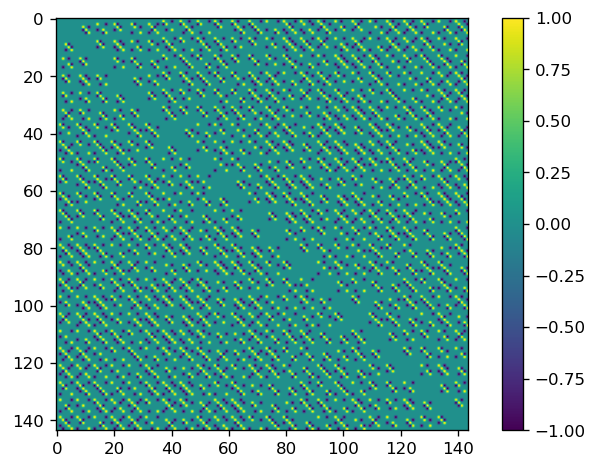

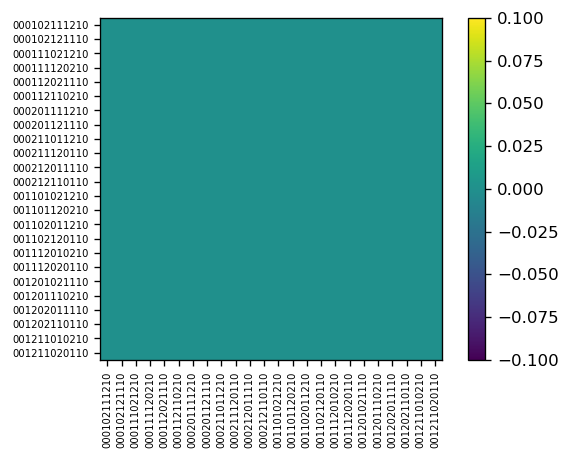

shapes
(144, 144)
(6, 6)
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 16 02:02:52 PM: Your problem has 1152 variables, 20737 constraints, and 0 parameters.
(CVXPY) Jul 16 02:02:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 16 02:02:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 16 02:02:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 16 02:02:52 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 16 02:02:52 PM: Compiling pro

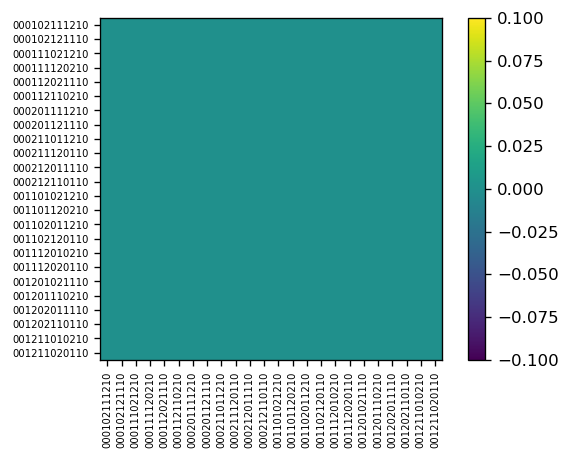

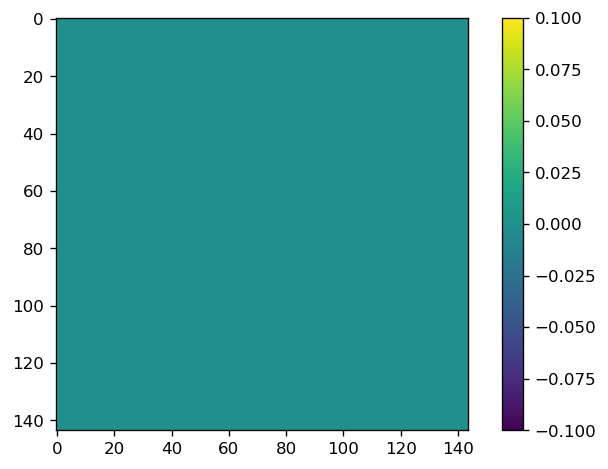

In [6]:
n = 2
m = 3
# print(get_n_cycles(n))
# cycles = get_cycles(n, n)
# print(cycles)
# mat = lv_search_mat(n, shift=k)
# visualize(mat, (cycles, cycles), to_string=True)
# perms, mat = index_or(n)
# perms = list(itertools.permutations)
# # perms = [perm for perm in perms.instances if perm.index(0)!=0]

# # prob = equality(n)
perms, keys, preimage_dict = get_special_cycles(n, m)

# perms = get_cycles(n,n)
# # # perms = perms[:3] + perms[-2:]
# keys, perm_types = search_perm_sorter(perms)
inv_keys = {v:key for key, v in keys.items()}
sorted_perms = [inv_keys[i] for i in range(len(keys))]
# print(keys)
# # # print(len(perms), len(keys))
oracles = get_oracles(perms, cycle_oracle)
# print(oracles)
# # # print(len(oracles))
oracle_diffs_list = get_oracle_diffs(oracles, prod=True, mat=True, keys=keys)
# # print(keys)
# # # print('blah', len(oracle_diffs_list), len(oracle_diffs_list[0]), oracle_diffs_list[0][0].shape)
# # # print(oracle_diffs_list)
oracle_diffs = np.block(oracle_diffs_list)
# perms_sorted = [keys.index[i] for i in range(len(keys))]
visualize(oracle_diffs)

mat = mask_maker(keys, preimage_dict)
visualize(mat, (sorted_perms, sorted_perms), to_string=True)
# print('boop')
# start = time()
Lambda, mu, W = relative_hadamard_norm_max(mat, oracle_diffs, len(perms))
visualize(Lambda, (sorted_perms, sorted_perms), to_string=True)
visualize(W)
# # visualize(W[] * oracle_diffs)
# print(mu)
# print("time",  time()-start)
# print(set(np.round(W.flatten(), 7)))

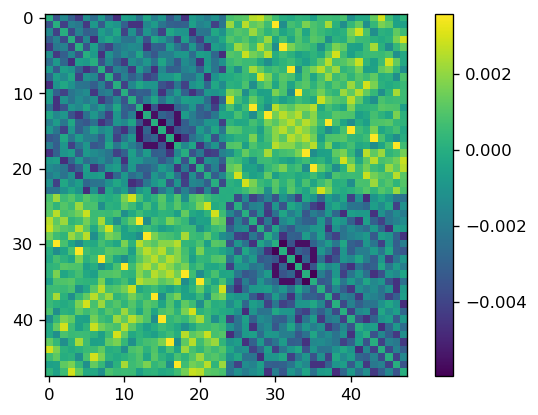

-0.005947288305162251
[[0.01855343 0.         0.         ... 0.         0.         0.        ]
 [0.         0.02263397 0.         ... 0.         0.         0.        ]
 [0.         0.         0.01802716 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.01802716 0.         0.        ]
 [0.         0.         0.         ... 0.         0.02263397 0.        ]
 [0.         0.         0.         ... 0.         0.         0.01855343]]


C:\Users\blake\AppData\Local\Temp/ipykernel_14140/1540595921.py:186: RuntimeWarning: invalid value encountered in true_divide
  G[x,y] = Lambda[x,y]/np.sqrt(mu[x] * mu[ y])


ValueError: setting an array element with a sequence.

In [9]:

def to_str(L):
    return ''.join([str(x) for x in L])
    


plt.imshow(Lambda)
plt.colorbar()
plt.show()
print(np.min(Lambda))
print(mu)
# print(len(set(prob.yes_instances)))
# print(prob.yes_instances)
# print(Lambda.shape)

# print(2*np.sum(Lambda))
# print(Lambda[0,1])
# print(np.linalg.eig(G))
G = to_adversary_mat(Lambda, mu)
# plt.imshow(G)
# plt.colorbar()
# plt.show()
# print(mat)
t = .5
print('G', np.linalg.eigvals(G)[0])
print('Gmat', np.linalg.eigvals(G*mat)[0])
visualize(G*mat,  (perms, perms), to_string=True, save="mat.png")
big_mat = np.kron(G, np.ones((n ,n)))*oracle_diffs
# big_mat = t*np.eye(big_mat.shape[0]) + big_mat
print('bigmat')
visualize(big_mat)
print('eig')
print(np.max(np.real(np.linalg.eigvals(big_mat))))
visualize(np.real(np.linalg.eig(big_mat)[1]))
print((np.real(np.linalg.eig(big_mat)[1][:, 0])))
# print(Lambda.shape)
# A,_ = adv_solver(prob)

In [ ]:
print(set(np.round(G.flatten()/np.max(G), 7)))

In [ ]:
print(G[0,1])

24 2
0 2.0627689033473415


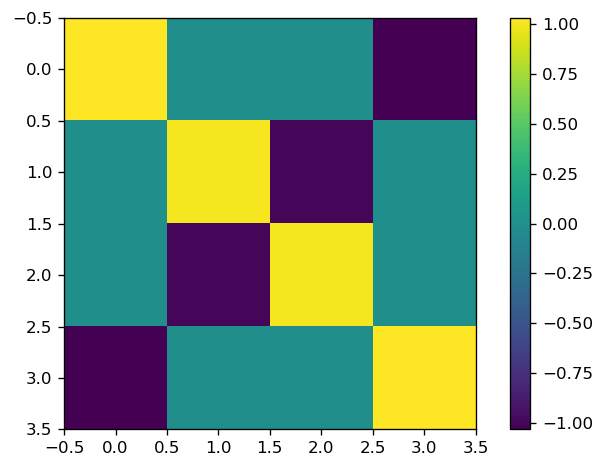

1 2.032838993646588


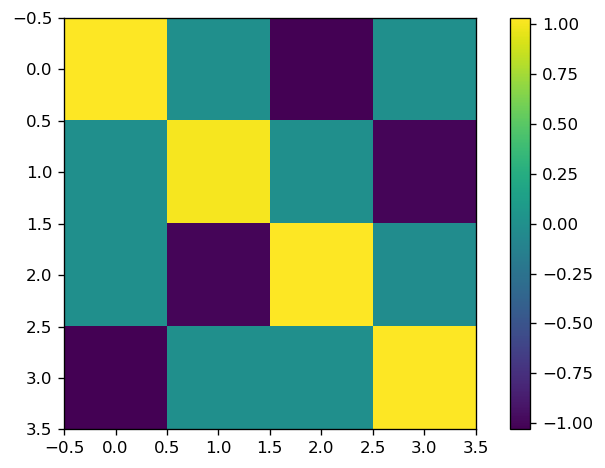

2 2.153032965278958


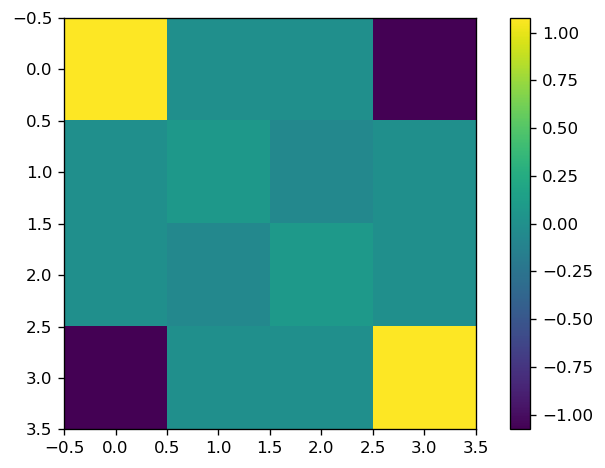

3 2.1530329659190954


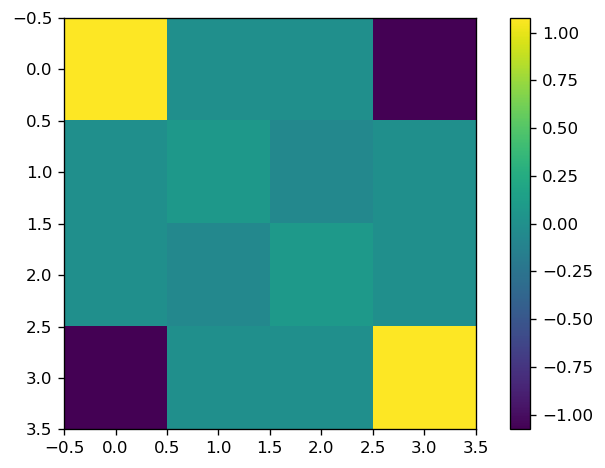

In [11]:
# print(oracle_diffs)
# print(oracle_diffs_list)
print(len(oracle_diffs_list), np.math.factorial(n-2))
fac = len(perm_types[0])
# print('fac', fac)
for j in range(n):
    curr_sum =  np.zeros((n, n))
    for i in list(range(0, j*fac)) + list(range((j+1)*fac, len(oracle_diffs_list))):
        curr_sum =G[j, i] * curr_sum + oracle_diffs_list[j][i]
    print(j, np.linalg.norm(curr_sum, 2))
    visualize(curr_sum)

In [46]:
perm_mat = oracle_diffs * np.kron(mat, np.ones((n, n)))
cevals, cevects = np.linalg.eig(mat)
print((np.round(np.real(1/cevects[0,0]), 9)))
print(set(np.round(np.real(evects[:, 0]), 9)))
# visualize(perm_mat)
evals, evects = np.linalg.eig(perm_mat)
# visualize(np.real(evects))
# visualize(oracle_diffs)
print(evals[0], cevals[0])
visualize(np.real(cevects))


# print(evals[0])
# print(evects[0, :])

10.95445115


NameError: name 'evects' is not defined

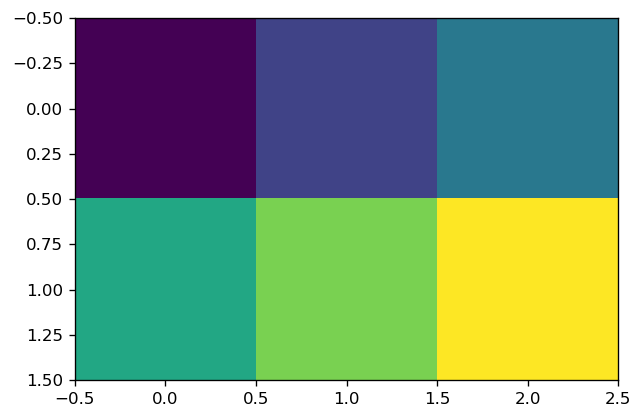

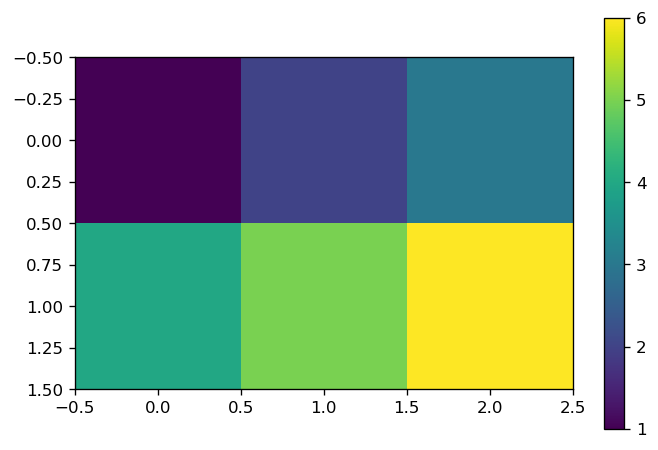

In [47]:
M = np.array([
[1,2,3],
[4,5,6]
])
plt.imshow(M)
plt.show()
visualize(M)

In [48]:
sym_perm_mat.eigenvals()

NameError: name 'sym_perm_mat' is not defined

In [49]:
M = Matrix([[1,0,0],[1,2,2], [3,2,1]])

NameError: name 'Matrix' is not defined

In [50]:
print(M)

[[1 2 3]
 [4 5 6]]


In [51]:
M.eigenvals()

AttributeError: 'numpy.ndarray' object has no attribute 'eigenvals'

In [52]:
perm_mat

array([[ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.]])

In [53]:
print(perm_types)

{0: [(0, 1, 2, 3, 4), (0, 1, 2, 4, 3), (0, 1, 3, 2, 4), (0, 1, 3, 4, 2), (0, 1, 4, 2, 3), (0, 1, 4, 3, 2), (0, 2, 1, 3, 4), (0, 2, 1, 4, 3), (0, 2, 3, 1, 4), (0, 2, 3, 4, 1), (0, 2, 4, 1, 3), (0, 2, 4, 3, 1), (0, 3, 1, 2, 4), (0, 3, 1, 4, 2), (0, 3, 2, 1, 4), (0, 3, 2, 4, 1), (0, 3, 4, 1, 2), (0, 3, 4, 2, 1), (0, 4, 1, 2, 3), (0, 4, 1, 3, 2), (0, 4, 2, 1, 3), (0, 4, 2, 3, 1), (0, 4, 3, 1, 2), (0, 4, 3, 2, 1)], 1: [(1, 0, 2, 3, 4), (1, 0, 2, 4, 3), (1, 0, 3, 2, 4), (1, 0, 3, 4, 2), (1, 0, 4, 2, 3), (1, 0, 4, 3, 2), (2, 0, 1, 3, 4), (2, 0, 1, 4, 3), (2, 0, 3, 1, 4), (2, 0, 3, 4, 1), (2, 0, 4, 1, 3), (2, 0, 4, 3, 1), (3, 0, 1, 2, 4), (3, 0, 1, 4, 2), (3, 0, 2, 1, 4), (3, 0, 2, 4, 1), (3, 0, 4, 1, 2), (3, 0, 4, 2, 1), (4, 0, 1, 2, 3), (4, 0, 1, 3, 2), (4, 0, 2, 1, 3), (4, 0, 2, 3, 1), (4, 0, 3, 1, 2), (4, 0, 3, 2, 1)], 2: [(1, 2, 0, 3, 4), (1, 2, 0, 4, 3), (1, 3, 0, 2, 4), (1, 3, 0, 4, 2), (1, 4, 0, 2, 3), (1, 4, 0, 3, 2), (2, 1, 0, 3, 4), (2, 1, 0, 4, 3), (2, 3, 0, 1, 4), (2, 3, 0, 4, 1),

In [54]:
global_perm_assignment = {}
count = 0
for t, ps in perm_types.items():
    for p in ps:
        global_perm_assignment[p] = count
        count += 1
# print(global_perm_assignment)

In [55]:
n =7
k = 2

# perms, mat = index_or(n)
# perms = list(itertools.permutations)
# perms = [perm for perm in perms.instances if perm.index(0)!=0]


perms = list(itertools.permutations(range(n)))
print('completed perms')
# # perms = perms[:3] + perms[-2:]
keys, perm_types = search_perm_sorter(perms)
print('perm types')
# # print(len(perms), len(keys))
oracles = get_oracles(perms, permutation_oracle)
print("oracles")
# # print(len(oracles))
oracle_diffs_list = get_oracle_diffs(oracles, keys=keys, prod=True, mat=True)
print("diff list")
# print(keys)
# # print('blah', len(oracle_diffs_list), len(oracle_diffs_list[0]), oracle_diffs_list[0][0].shape)
# # print(oracle_diffs_list)
oracle_diffs = np.block(oracle_diffs_list)
print("block")
# visualize(oracle_diffs)
mat = search_mask(perms, assignment=keys)
# print(mat)
diff_mat = oracle_diffs*np.kron(mat, np.ones((n,n)))

print(np.linalg.norm(diff_mat, 2), np.linalg.norm(oracle_diffs, 2), np.linalg.norm(np.ones(mat.shape), 2))

# visualize(diff_mat)
# visualize(oracle_diffs)

block_size = len(perm_types[1])
for i in range(n):
    for j in range(n):
        if i != j:
            starti = i * block_size * n
            endi = starti + block_size * n
            startj = j * block_size * n
            endj = startj + block_size *n
            curr_block = oracle_diffs[starti: endi, startj:endj]
            print(i,j, np.linalg.norm(curr_block, 2))
            # visualize(curr_block)
            

completed perms
perm types
get_oracles 5040
oracles
diff list


KeyboardInterrupt: 